In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera

# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement
import math
import scipy.io as sio
import random
import os
import cv2
import random

# Ray Tracing

In [2]:
pi_value = math.pi
def generate_SS_map(building, tx_pos = [0, 0, 25], batch_size = 10000, index = 1):
    
    ant_dir = np.random.uniform(0, 2*pi_value)
    
    ant_dir_file_name = f'Data/BS_info/{building}.txt'
    with open(ant_dir_file_name, 'a') as file:  
        file.write(f"Index {index} : {building} Tx at [{tx_pos[0]}, {tx_pos[1]}, {tx_pos[2]}] with dir : {ant_dir} \n")
        
    
    scene = load_scene(f'building_xml/{building}.xml')
    # scene_plane = load_scene('Plane/Plane1.xml')
    scene.frequency = 3.5e9 # in Hz; implicitly updates RadioMaterials
            
    ######### scene_building settings ###############################
    scene.tx_array = PlanarArray(num_rows=1,
                                            num_cols=1,
                                            vertical_spacing=0.5,
                                            horizontal_spacing=0.5,
                                            pattern="tr38901",
                                            polarization="VH")

    # Configure antenna array for all receivers
    scene.rx_array = PlanarArray(num_rows=1,
                                            num_cols=1,
                                            vertical_spacing=0.5,
                                            horizontal_spacing=0.5,
                                            pattern="iso",
                                            polarization="VH")

    # Create transmitter
    tx = Transmitter(name="tx",
                        position=tx_pos,
                        orientation=[ant_dir,0,0],
                        # color=(1, 0, 0)
                        )
                
    scene.add(tx)
    scene.synthetic_array = True
    cm = scene.coverage_map(max_depth=3, 
                                    los=True, 
                                    reflection=True, 
                                    diffraction=True, 
                                    check_scene=False)
    ##################################################################

       
    # Open the file and read its contents
    with open(f'Data/UE_loc/UE_pos_{building}.txt', 'r') as file:
        lines = file.readlines()

    # Initialize an empty list to store the coordinates
    ue_pos = []

    # Loop through each line in the file
    for line in lines:
        # Extract the numbers inside the brackets and convert them to floats
        coord = [float(num) for num in line.strip().strip('[]').split()]
        # Add the coordinate to the list
        ue_pos.append(coord)

            
    # change coverage map into tensor
    cm_tensor = cm.as_tensor()
    cm_2D = cm_tensor.numpy()[0, :, :]
    cm_2D = np.flip(cm_2D[::-1])
                
    # cm_2D = np.resize(cm_2D, (128, 128))
            
    # change W into dB
    cm_db = 10 * np.log10(cm_2D)
    shape = cm_db.shape
    # print(shape)
                    
    np.save(f'Data/PGmap/PGmap_{building}_{index}.npy', cm_db)                                
    ############################### ray tracing #####################################################
    UE_num = 0
    UE_position_list = []
    for i in range(batch_size):
        rx = Receiver(name=f"rx-{i}",
                    position=ue_pos[i], # Random position sampled from coverage map
                    )
        scene.add(rx)
        
        paths = scene.compute_paths(max_depth=3,
                            method='fibonacci',
                            num_samples=1e5,
                            los = True,
                            reflection=True,
                            diffraction=True,
                            check_scene=True,
                            # scattering=True,
                            edge_diffraction=True,
                            # scat_keep_prob=0.5
                            )
    
        ray_num = len(paths.types.numpy()[0])
        print(f"ray number : {ray_num}")
                  
        path_gain_list = []
        path_phase_list = []
        path_delay_list = []
        path_AOD_hor_list = []
        path_AOD_ver_list = []
        path_AOA_hor_list = []
        path_AOA_ver_list = []
    
        count = 0
        for j in range(ray_num):
            path_idx = j 
            # For a detailed overview of the dimensions of all properties, have a look at the API documentation
            # print(f"\n--- Detailed results for path {path_idx} ---")

            # print(f"Channel coefficient: {paths.a[0,0,0,0,0,path_idx, 0].numpy()}")
            path_coefficients = paths.a[0,0,0,0,0,path_idx, 0].numpy()
            if path_coefficients == 0:
                continue
            path_gain = np.abs(path_coefficients)
            path_phase = np.angle(path_coefficients)
            path_gain_list.append(path_gain)
            path_phase_list.append(path_phase)

            # print(f"Propagation delay: {paths.tau[0,0,0,path_idx].numpy()*1e6:.8f} us")
            path_delay = paths.tau[0,0,0,path_idx].numpy()
            path_delay_list.append(path_delay)

            # print(f"Zenith angle of departure: {paths.theta_t[0,0,0,path_idx]:.4f} rad")
            path_AOD_ver = paths.theta_t[0,0,0,path_idx]
            path_AOD_ver_list.append(path_AOD_ver)

            # print(f"Azimuth angle of departure: {paths.phi_t[0,0,0,path_idx]:.4f} rad")
            path_AOD_hor = paths.phi_t[0,0,0,path_idx]
            path_AOD_hor_list.append(path_AOD_hor)

            # print(f"Zenith angle of arrival: {paths.theta_r[0,0,0,path_idx]:.4f} rad")
            path_AOA_ver = paths.theta_r[0,0,0,path_idx]
            path_AOA_ver_list.append(path_AOA_ver)

            # print(f"Azimuth angle of arrival: {paths.phi_r[0,0,0,path_idx]:.4f} rad")
            path_AOA_hor = paths.phi_r[0,0,0,path_idx]
            path_AOA_hor_list.append(path_AOA_hor)
            count += 1
            if count >= 297:
                break
        k = len(path_gain_list)    
        
        def pad_to_297(arr_list):
            arr = np.array(arr_list).reshape(-1, 1)
            return np.pad(arr, ((0, 297 - arr.shape[0]), (0, 0)), 'constant', constant_values=0)

        path_gains = pad_to_297(path_gain_list)
        path_phases = pad_to_297(path_phase_list)
        path_delays = pad_to_297(path_delay_list)
        path_AOA_hors = pad_to_297(path_AOA_hor_list)
        path_AOA_vers = pad_to_297(path_AOA_ver_list)
        path_AOD_hors = pad_to_297(path_AOD_hor_list)
        path_AOD_vers = pad_to_297(path_AOD_ver_list)

        if np.all(path_gains == 0):
            scene.remove(f"rx-{i}")
            print(f"skip data{i}")  
            continue
    
        else:
            UE_position_list.append(ue_pos[i])
            UE_postion_arr = np.array(UE_position_list).reshape(-1, 3)
            UE_num += 1
        
            data_dict = {
            'path_gain': path_gains,
            'path_phase': path_phases,
            'path_delay': path_delays,
            'path_AOA_hor': path_AOA_hors,
            'path_AOA_ver': path_AOA_vers,
            'path_AOD_hor': path_AOD_hors,
            'path_AOD_ver': path_AOD_vers,
            }

            mat_struct = {'sim': data_dict}
            folder_path = f'Data/data_all'
            if not os.path.exists(folder_path):
                os.makedirs(folder_path)
                sio.savemat(f'Data/data_all/data{i+1}.mat', mat_struct)
            else:
                sio.savemat(f'Data/data_all/data{i+1}.mat', mat_struct)

            print(f"data{i+1} file created successfully.")
            # print("##############################################")
            scene.remove(f"rx-{i}")
            # print(f"rx-{i} removed")
        
    pos_dict = {
    'agent_num' : UE_num,
    'agent' : UE_postion_arr,
    'anchor_num' : 1,
    'anchor' : tx_pos
    }
    os.makedirs(f'C:\\Users\\User\\Desktop\\MIMO_Throughput_Sim-V3.2\\{building}_{index}')
    sio.savemat(f'C:\\Users\\USER\\Desktop\\MIMO_Throughput_Sim-V3.2\\{building}_{index}\\position.mat', pos_dict)

In [3]:
import random
import os
import re

for index in range(2, 11):
    building = 'building5'
    # random select position of BS
    # make sure that the position haven't been selected before(check it through "Data/ant_dir_building{num}.txt")
    x_min, x_max = -506, 529
    y_min, y_max = -544, 525

    random_x = random.uniform(x_min, x_max)
    random_y = random.uniform(y_min, y_max)

    print(f"Tx x coordinate : {random_x}")
    print(f"Tx y coordinate : {random_y}")

    generate_SS_map(building = building, tx_pos = [random_x, random_y, 25], batch_size = 10000, index = index)
    
    # ReIndex the files


    # 设置目标文件夹路径
    folder_path = f'Data/data_all'
    output_folder = f'C:\\Users\\USER\\Desktop\\MIMO_Throughput_Sim-V3.2\\{building}_{index}\\data_all'

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # 获取文件夹中的所有 .mat 文件并按名称排序
    files = sorted([f for f in os.listdir(folder_path) if f.endswith('.mat')], key=lambda x: int(re.findall(r'\d+', x)[0]))
    print(files)


    # 初始化文a件重命名的起始编号
    new_index = 1

    for file_name in files:
        # 提取原文件的编号
        current_index = int(re.findall(r'\d+', file_name)[0])

        # 生成新文件名
        new_file_name = f"data{new_index}.mat"

        # 获取完整路径
        old_file_path = os.path.join(folder_path, file_name)
        new_file_path = os.path.join(output_folder, new_file_name)

        # 进行重命名
        os.rename(old_file_path, new_file_path)
    
        # 输出信息以确认操作
        print(f"重命名: {file_name} -> {new_file_name}")

        # 更新新文件名的编号
        new_index += 1



Tx x coordinate : -450.36856222760025
Tx y coordinate : 104.31308911785425


C:\Users\User\AppData\Local\Temp\ipykernel_16592\1016131037.py:71: RuntimeWarning: divide by zero encountered in log10
  cm_db = 10 * np.log10(cm_2D)


ray number : 11
data1 file created successfully.
ray number : 7
data2 file created successfully.
ray number : 4
data3 file created successfully.
ray number : 4
data4 file created successfully.
ray number : 2
data5 file created successfully.
ray number : 1
data6 file created successfully.
ray number : 1
data7 file created successfully.
ray number : 1
data8 file created successfully.
ray number : 1
data9 file created successfully.
ray number : 1
data10 file created successfully.
ray number : 1
data11 file created successfully.
ray number : 3
data12 file created successfully.
ray number : 1
data13 file created successfully.
ray number : 1
data14 file created successfully.
ray number : 1
data15 file created successfully.
ray number : 2
data16 file created successfully.
ray number : 2
data17 file created successfully.
ray number : 2
data18 file created successfully.
ray number : 2
data19 file created successfully.
ray number : 1
data20 file created successfully.
ray number : 1
data21 file c

In [5]:
import random
import os
import re

# ReIndex the files
building = 'building31'
index = 1

# 设置目标文件夹路径
folder_path = f'Data/data_all'
output_folder = f'C:\\Users\\USER\\Desktop\\MIMO_Throughput_Sim-V3.2\\{building}_{index}\\data_all'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
# 获取文件夹中的所有 .mat 文件并按名称排序
files = sorted([f for f in os.listdir(folder_path) if f.endswith('.mat')], key=lambda x: int(re.findall(r'\d+', x)[0]))
print(files)


# 初始化文a件重命名的起始编号
new_index = 1

for file_name in files:
        # 提取原文件的编号
        current_index = int(re.findall(r'\d+', file_name)[0])

        # 生成新文件名
        new_file_name = f"data{new_index}.mat"

        # 获取完整路径
        old_file_path = os.path.join(folder_path, file_name)
        new_file_path = os.path.join(output_folder, new_file_name)

        # 进行重命名
        os.rename(old_file_path, new_file_path)
    
        # 输出信息以确认操作
        print(f"重命名: {file_name} -> {new_file_name}")

        # 更新新文件名的编号
        new_index += 1

['data1.mat', 'data2.mat', 'data3.mat', 'data4.mat', 'data5.mat', 'data6.mat', 'data7.mat', 'data8.mat', 'data9.mat', 'data10.mat', 'data11.mat', 'data12.mat', 'data13.mat', 'data14.mat', 'data15.mat', 'data16.mat', 'data17.mat', 'data18.mat', 'data19.mat', 'data20.mat', 'data21.mat', 'data22.mat', 'data23.mat', 'data24.mat', 'data25.mat', 'data26.mat', 'data27.mat', 'data28.mat', 'data29.mat', 'data30.mat', 'data31.mat', 'data32.mat', 'data33.mat', 'data34.mat', 'data35.mat', 'data36.mat', 'data37.mat', 'data38.mat', 'data39.mat', 'data40.mat', 'data41.mat', 'data42.mat', 'data43.mat', 'data44.mat', 'data45.mat', 'data46.mat', 'data47.mat', 'data48.mat', 'data49.mat', 'data50.mat', 'data51.mat', 'data52.mat', 'data53.mat', 'data54.mat', 'data55.mat', 'data56.mat', 'data57.mat', 'data58.mat', 'data59.mat', 'data60.mat', 'data61.mat', 'data62.mat', 'data63.mat', 'data64.mat', 'data65.mat', 'data66.mat', 'data67.mat', 'data68.mat', 'data69.mat', 'data70.mat', 'data71.mat', 'data72.mat', 

Please go to MIMO_Throughput_sim to compute throughput.
After running throughput, come back and run the code below to resize your data.

# Resize to training data

In [2]:
building = 'building1'
index = 1

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Load the .mat file
building = 'building1'
for index in range(107, 121):
    data = sio.loadmat(f'C:\\Users\\USER\\Desktop\\MIMO_Throughput_Sim-V3.2\\Report\\{building}_{index}')

    # Display the keys in the dictionary (these are the variable names in the .mat file)
    # print(data.keys())

    # Accessing a specific variable from the .mat file
    variable_name = 'Throughput_ALL'  # Replace with your actual variable name
    if variable_name in data:
        Throughput_data = data[variable_name]
        print(Throughput_data)
    else:
        print(f"{variable_name} not found in the .mat file.")
    
    # Load the .mat file
    data = sio.loadmat(f'C:\\Users\\USER\\Desktop\\MIMO_Throughput_Sim-V3.2\\{building}_{index}\\position.mat')

    # Display the keys in the dictionary (these are the variable names in the .mat file)
    # print(data.keys())

    # Accessing a specific variable from the .mat file
    variable_name = 'agent'  # Replace with your actual variable name
    if variable_name in data:
        coordinates = data[variable_name]
        # print(data[variable_name])
    else:
        print(f"{variable_name} not found in the .mat file.")
    
    x_coords = coordinates[:, 0]  # All rows, first column (x values)
    y_coords = coordinates[:, 1]  # All rows, second column (y values)

    # Ensure the inputs are 1D arrays
    x_coords = np.ravel(x_coords)
    y_coords = np.ravel(y_coords)
    Throughput_data = np.ravel(Throughput_data)

    # Ensure that all arrays have the same length
    assert len(x_coords) == len(y_coords) == len(Throughput_data)

    # Define the number of bins
    num_bins = 100

    # Create 2D histogram for weighted sum
    H, xedges, yedges = np.histogram2d(x_coords, y_coords, bins=num_bins, weights=Throughput_data)

    # Count the number of points in each bin (without weights)
    H_counts, _, _ = np.histogram2d(x_coords, y_coords, bins=num_bins)

    # Calculate the mean, setting bins with no data points to a very small value
    Throughput_map = np.divide(H, H_counts, out=np.zeros_like(H), where=H_counts != 0)
    # np.save(f'Throughput_map_1e4_depth3_100.npy', Throughput_map.T)

    Throughput_map = cv2.resize(Throughput_map, (128, 128), interpolation=cv2.INTER_AREA)

    # Randomly sample a sparse throughput map
    Sparse_throughput_map = np.zeros(shape=(128, 128))

    num_points = random.randint(80, 201)
    print(f"Number of sampled points: {num_points}")

    rows = np.random.randint(0, Throughput_map.T.shape[0], num_points)
    cols = np.random.randint(0, Throughput_map.T.shape[1], num_points)

    for row, col in zip(rows, cols):
        Sparse_throughput_map[row, col] = Throughput_map.T[row, col]

    # Optional: Apply interpolation or smoothing to fill in gaps in the sparse map
    Sparse_throughput_map = cv2.resize(Sparse_throughput_map, (128, 128), interpolation=cv2.INTER_AREA)

    print(f"Sparse throughput map shape: {Sparse_throughput_map.shape}")
    np.save(f'Data/Sparse_throughput_map/Sparse_throughput_map_{building}_{index}.npy', Sparse_throughput_map)

    print(f"Throughput map shape: {Throughput_map.shape}")
    np.save(f'Data/Throughput_map/Throughput_map_{building}_{index}.npy', Throughput_map.T)

    # Calculate the extents to place the origin at the center
    height, width = Throughput_map.shape
    extent = (-width // 2, width // 2, -height // 2, height // 2)


[[  73.728]
 [   0.   ]
 [ 327.904]
 ...
 [ 835.904]
 [1279.136]
 [ 983.904]]
Number of sampled points: 144
Sparse throughput map shape: (128, 128)
Throughput map shape: (128, 128)
[[1147.904]
 [1409.76 ]
 [1147.904]
 ...
 [   0.   ]
 [  19.488]
 [   0.   ]]
Number of sampled points: 180
Sparse throughput map shape: (128, 128)
Throughput map shape: (128, 128)
[[1409.76]
 [1409.76]
 [1409.76]
 ...
 [   0.  ]
 [   0.  ]
 [   0.  ]]
Number of sampled points: 103
Sparse throughput map shape: (128, 128)
Throughput map shape: (128, 128)
[[ 467.168]
 [ 467.168]
 [ 467.168]
 ...
 [1147.904]
 [1279.136]
 [1147.904]]
Number of sampled points: 81
Sparse throughput map shape: (128, 128)
Throughput map shape: (128, 128)
[[1279.136]
 [1409.76 ]
 [1409.76 ]
 ...
 [   0.   ]
 [   0.   ]
 [  12.96 ]]
Number of sampled points: 199
Sparse throughput map shape: (128, 128)
Throughput map shape: (128, 128)
[[770.496]
 [655.904]
 [770.496]
 ...
 [467.168]
 [467.168]
 [467.168]]
Number of sampled points: 83
S

Throughput map shape : (128, 128)
Sparse Throughput map shape : (128, 128)


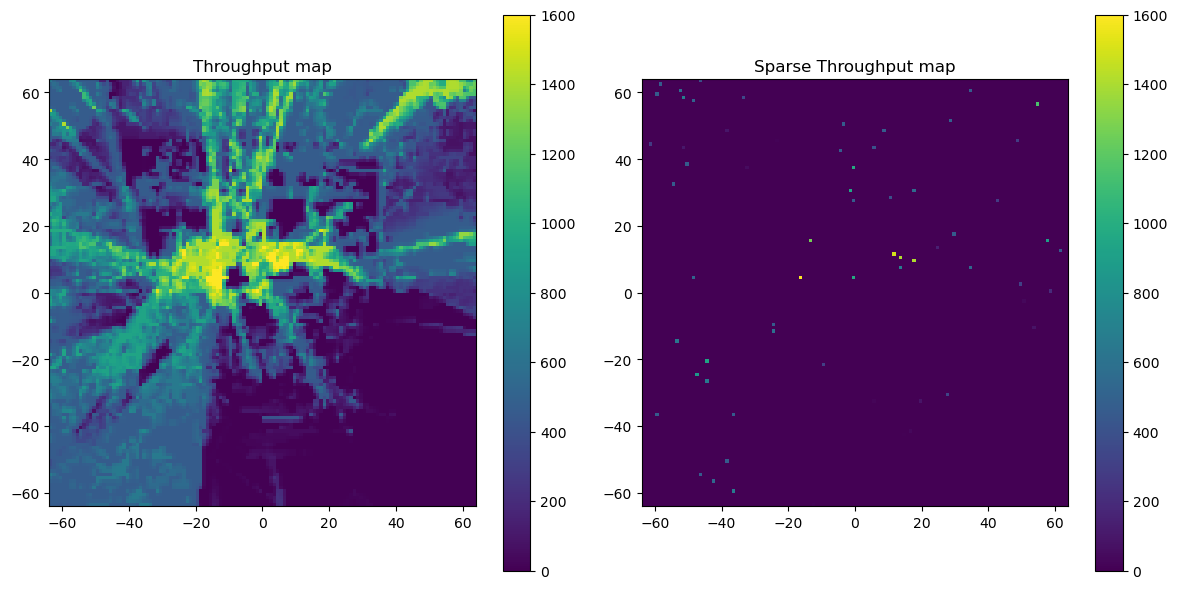

In [5]:
building = 'building1'
index = 110

Throughput_map = np.load(f'Data/Throughput_map/Throughput_map_{building}_{index}.npy')
Sparse_throughput_map = np.load(f'Data/Sparse_throughput_map/Sparse_throughput_map_{building}_{index}.npy')

print(f"Throughput map shape : {Throughput_map.shape}")
print(f"Sparse Throughput map shape : {Sparse_throughput_map.shape}")


height, width = Throughput_map.shape
extent = (-width // 2, width // 2, -height // 2, height // 2)

# Determine the common color scale limits
vmin = 0
vmax = 1600

plt.figure(figsize=(12, 6))

# First subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.imshow(Throughput_map, extent=extent, origin='lower', vmin=vmin, vmax=vmax)
plt.title('Throughput map')
plt.colorbar()

# Second subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.imshow(Sparse_throughput_map, extent=extent, origin='lower', vmin=vmin, vmax=vmax)
plt.title('Sparse Throughput map')
plt.colorbar()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()
